### In this notebook I will try to design yolov1 from stratch in pytorch. The code will be basic and understandable anyone who know about pytorchs nn module and basic training steps. I will be trying to comment anything that you might miss.
### You can read the original paper  <a href = 'https://arxiv.org/pdf/1506.02640.pdf'>here </a>.
### Some parts of this code taken from  <a href = 'https://www.youtube.com/watch?v=n9_XyCGr-MI'>Aladdin Persson </a> video.

In [38]:
import torch
import torch.nn as nn
import os
from PIL import Image

## 1. Creating the Model 
We will create the original yolov1 model from scartch so if you are not familiar with the model you can check this image.
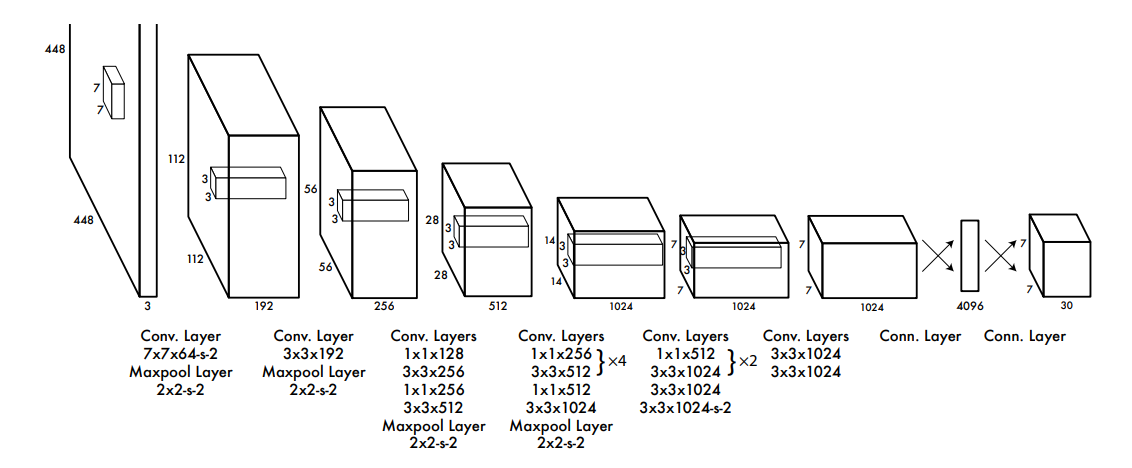

First we will define a basic CNNBlock for our architecture.We will be using leaky ReLU as activation function. We will add a batch norm to our model although original yolo didnt have but it will help training and accuracy so we will include it.

In [20]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels, out_channels ,kernel_size = 3, stride =1  , padding = 1):## if groups = in_channels then this is depth_wise convolution operation
        super(CNNBlock , self).__init__()
        self.conv2d = nn.Conv2d(in_channels = in_channels , out_channels = out_channels , kernel_size = kernel_size , stride = stride , padding = padding , bias = False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)
    def forward(self,x):
        return self.leaky_relu(self.batchnorm(self.conv2d(x)))
    
    

If you want to learn more about pytorch conv2d you check <a href = "https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html">this</a> link

This picture shows how the model is doing!
And we will discuss how to remove redundant boxes later.(SPOILER: non-max supression)

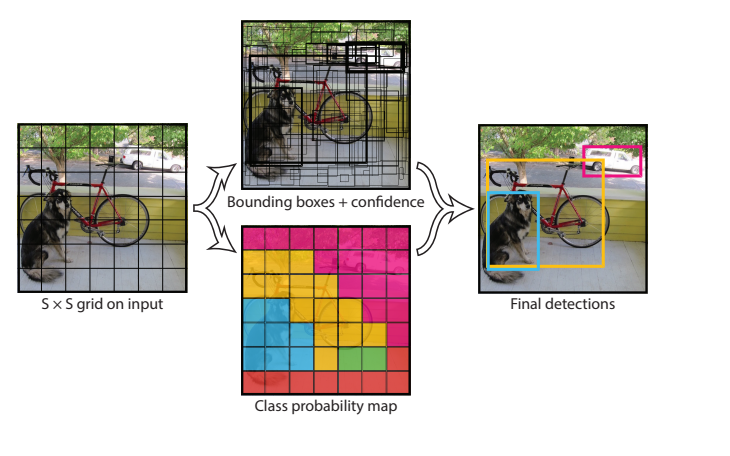


In [21]:
class YoloV1(nn.Module):
    def __init__(self,grid_size,n_box , n_class , input_channels = 3):# S = grid_size , n_box = Bounding boxes , n_class = how many classes for classification!
        super(YoloV1 , self).__init__()
        ## This will be a long one so you can pass it if you want. Basicly creating the same model on the pic. above.
        
        self.darknet = nn.Sequential(
                     CNNBlock(in_channels = input_channels , out_channels = 64,kernel_size = 7 , stride = 2 , padding = 3),
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 64 , out_channels = 192,kernel_size = 3 , stride = 2 , padding = 1),   
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 192 , out_channels = 128,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 128 , out_channels = 256,kernel_size = 3 , stride = 1 , padding = 1),    
                     CNNBlock(in_channels = 256 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),   
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),    
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),      
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),    
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),
                     CNNBlock(in_channels = 512 , out_channels = 512,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 512 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1), 
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 1024 , out_channels = 512,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 512 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1),
                     CNNBlock(in_channels = 1024 , out_channels = 512,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 512 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 2 , padding = 2), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 2), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1),   
                        )
        self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear((1024*grid_size*grid_size) , 4096), #output of darknet will be S x S x 1024
                nn.Dropout(0.4),
                nn.LeakyReLU(0.1),
                nn.Linear(4096 , grid_size*grid_size*(n_class + n_box*5)) # there will be n_class + n_box*5 outputs for each grid (we multiplt n_box with  5 because each box contains; midpoint_x , midpoint_y , width , height ,confidence  )
                )
        
    def forward(self,x):
        x = self.darknet(x)
        return self.fc(x)
        
        
        

In [22]:
## Test the model for S = 7 , Box = 2 , Classes = 20 

# Expected output shape [2,1470] where 1470 is 7 x 7  x (5 x 2 + 20)

#model = YoloV1(7,2,20)
#x = torch.randn((2,3,448,448))
#print(model(x).shape)

## Utility Functions

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

In [24]:
def IOU(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    '''
    这段代码是计算两个边界框（Bounding Boxes）的交并比（Intersection over Union，IoU）的函数。交并比是一种衡量两个边界框重叠程度的指标，值越大表示重叠程度越高。
    函数接收两个参数：boxes_preds和boxes_labels，分别代表预测的边界框和实际的边界框。每个边界框由四个值表示，如果box_format为"midpoint"，
    则这四个值为中心点的x、y坐标和宽度、高度；如果box_format为"corners"，则这四个值为左上角和右下角的x、y坐标。
    在函数中，首先根据box_format的值，计算出两个边界框的左上角和右下角的坐标。然后，计算两个边界框的交集区域的坐标。
    接着，计算交集区域的面积，以及两个边界框的面积。最后，返回交集区域的面积除以两个边界框面积的并集，即为交并比。

    "midpoint(中心点)"和"corners(角落)"是两种不同的边界框（Bounding Box）表示方法。

    1. "midpoint"：这种表示方法使用边界框的中心点坐标（x，y）以及边界框的宽度（w）和高度（h）来定义边界框。
    这种表示方法在某些情况下更方便，例如在计算边界框的大小或位置变化时。

    2. "corners"：这种表示方法使用边界框左上角和右下角的坐标（x1，y1，x2，y2）来定义边界框。这种表示方法在其他情况下可能更方便，例如在计算边界框的交集或并集时。
    在计算IOU（交并比）时，需要先将两种表示方法统一为同一种形式。
    '''

    if box_format == "midpoint":
        '''
        这段代码是用于计算边界框（Bounding Box）的四个角点坐标的。在这里，边界框是由中心点坐标（x，y）以及宽度（w）和高度（h）来定义的，这种表示方法被称为"midpoint"。
        具体来说：
        - box1_x1 和 box1_y1 计算的是第一个边界框的左上角（x1，y1）的坐标。
        - box1_x2 和 box1_y2 计算的是第一个边界框的右下角（x2，y2）的坐标。
        - box2_x1 和 box2_y1 计算的是第二个边界框的左上角（x1，y1）的坐标。
        - box2_x2 和 box2_y2 计算的是第二个边界框的右下角（x2，y2）的坐标。
        这四个坐标点可以用来确定边界框在图像中的具体位置和大小。
        '''

        '''
        在Python中，[..., 0:1]是numpy数组的高级索引（Advanced Indexing）用法。这里的...表示省略，用于表示多个冒号（:）。
        具体来说，[..., 0:1]表示选取最后一个维度的第0个到第1个元素，返回的结果仍然保持原数组的维度。
        例如，如果我们有一个形状为(10, 10, 3)的三维数组a，a[..., 0:1]将会返回一个形状为(10, 10, 1)的数组，其中包含了原数组在最后一个维度（颜色通道维度）上的第0个元素。
        这种索引方式在处理多维数组时非常有用，可以让我们方便地选取、修改数组的特定部分。
        '''

        '''
        这里的0:1表示是左闭右开区间吗？即只取到索引为0的元素，而不取到索引为1的元素
        是的，你的理解是正确的。在Python中，切片操作使用的是左闭右开区间。所以0:1实际上只会选取索引为0的元素。
        例如，如果我们有一个列表a = [10, 20, 30, 40, 50]，a[0:1]将会返回一个新的列表[10]，只包含了原列表中索引为0的元素。
        同样，在这段代码中，boxes_preds[..., 0:1]将会选取boxes_preds在最后一个维度上索引为0的元素，返回的结果仍然保持原数组的维度。 
        '''

        '''
        boxes_preds[]里面是什么？
        boxes_preds是一个多维数组，通常用于存储预测的边界框信息。在这个上下文中，boxes_preds的每个元素都是一个边界框，
        每个边界框由四个值表示：中心点的x坐标、中心点的y坐标、宽度和高度。
        在boxes_preds[..., 0:1]这样的表达式中，...表示所有前面的维度，0:1表示最后一个维度的第0个元素。
        所以，boxes_preds[..., 0:1]会选取boxes_preds在最后一个维度上索引为0的元素，这个元素表示边界框的中心点的x坐标。
        类似地，boxes_preds[..., 1:2]会选取边界框的中心点的y坐标，boxes_preds[..., 2:3]会选取边界框的宽度，boxes_preds[..., 3:4]会选取边界框的高度。
        '''

        '''
        为什么这里boxes_preds[..., 0:1]不写成boxes_preds[..., 0]
        在Python中，boxes_preds[..., 0]和boxes_preds[..., 0:1]的主要区别在于返回的结果的维度。
        - boxes_preds[..., 0]会返回一个降低一个维度的数组。例如，如果boxes_preds的形状是(10, 10, 4)，那么boxes_preds[..., 0]的形状就会是(10, 10)。
        - boxes_preds[..., 0:1]会返回一个保持原始维度的数组。还是上面的例子，如果boxes_preds的形状是(10, 10, 4)，那么boxes_preds[..., 0:1]的形状就会是(10, 10, 1)。
        在这段代码中，为了保持操作的一致性和后续计算的方便，选择使用boxes_preds[..., 0:1]来保持原始的维度。
        '''

        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2 #求解第一个边界框的左上角横坐标，中心点的x坐标减去宽度的一半
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2 #求解第一个边界框的左上角纵坐标，中心点的y坐标减去高度的一半
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2 #求解第一个边界框的右下角横坐标，中心点的x坐标加上宽度的一半
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2 #求解第一个边界框的右下角纵坐标，中心点的y坐标加上高度的一半
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2 #求解第二个边界框的左上角横坐标，中心点的x坐标减去宽度的一半
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2 #求解第二个边界框的左上角纵坐标，中心点的y坐标减去高度的一半
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2 #求解第二个边界框的右下角横坐标，中心点的x坐标加上宽度的一半
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2 #求解第二个边界框的右下角纵坐标，中心点的y坐标加上高度的一半

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1] #求解第一个边界框的左上角横坐标，即第一个边界框的x1
        box1_y1 = boxes_preds[..., 1:2] #求解第一个边界框的左上角纵坐标，即第一个边界框的y1
        box1_x2 = boxes_preds[..., 2:3] #求解第一个边界框的右下角横坐标，即第一个边界框的x2
        box1_y2 = boxes_preds[..., 3:4] #求解第一个边界框的右下角纵坐标，即第一个边界框的y2
        box2_x1 = boxes_labels[..., 0:1] #求解第二个边界框的左上角横坐标，即第二个边界框的x1
        box2_y1 = boxes_labels[..., 1:2] #求解第二个边界框的左上角纵坐标，即第二个边界框的y1
        box2_x2 = boxes_labels[..., 2:3] #求解第二个边界框的右下角横坐标，即第二个边界框的x2
        box2_y2 = boxes_labels[..., 3:4] #求解第二个边界框的右下角纵坐标，即第二个边界框的y2



    #求解IOU见 https://zhuanlan.zhihu.com/p/473224484
    #请注意，在计算机图形学中，坐标系是以左上角作为原点，x轴向右，y轴向下的。所以，左上角的坐标值会比右下角的坐标值小。
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    '''
    clamp(min)是PyTorch中的一个函数，用于将张量中的元素限制在一个范围内。在这个例子中，clamp(0)将张量中所有小于0的元素都设置为0。
    这在计算交并比（Intersection over Union，IoU）时非常有用。当两个边界框没有交集（也就是说，它们的位置没有重叠）时，交集区域的宽度和高度会是负数。
    这时，我们可以使用clamp(0)将它们限制为0，表示交集区域的面积为0。
    这样，即使两个边界框没有交集，我们也可以正确地计算出交并比为0。
    '''
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    '''
    分母加了一个1e-6是为什么？在数学中，任意两个非空集，他们的并集不可能为空集吧，因此在计算IOU中分母怎么会为0呢？，那又为何要加上1e-6？
    你提到的是一个合理的观察，确实在理论上，两个非空集的并集不应为空集。然而，在计算机浮点数表示中，由于有限的精度，可能会出现极小的数值，使得分母在数值上接近零。
    为了避免除以零的错误，通常会在分母中添加一个很小的常数，例如 `1e-6`。以确保在计算 IoU 时不会出现除零错误。
    这个小常数 `1e-6` 的选择通常是经验性的，并不是一个精确的数学要求。它的目的是确保在实际计算中不会出现意外的错误，特别是在计算机中进行浮点数运算时。这种做法是一种常见的数值稳定性技巧。
    '''
    return intersection / (box1_area + box2_area - intersection + 1e-6)

非极大值抑制（Non-Maximum Suppression，NMS），顾名思义就是抑制不是极大值的元素，可以理解为局部最大搜索。

算法的实现过程为：
输入： 候选边界框集合B(每个候选框都有一个置信度)、IoU阈值N 输出： 最终的边界框集合D(初始为空集合) 
1.对集合B根据置信度进行降序排序； 
2.从集合B中选择第一个候选框(置信度最高)，把它放入集合D中并从集合B中删除； 
3.遍历集合B中的每个候选框，计算它们与D集合中这个候选框的IoU值。如果IoU值大于阈值N，则把它从集合B中删除；
4. 重复步骤2~3直到集合B为空。

以下代码实现的是一种变体的非极大值抑制（NMS）算法，而不是最原始的NMS算法。
在原始的NMS算法中，我们会保留置信度最高的边界框，然后移除与其IoU超过某个阈值的所有边界框。这个过程会重复进行，直到没有边界框可以移除。
然而，在这段代码中，除了考虑IoU阈值外，还考虑了边界框的类别。只有当两个边界框的类别相同，并且它们的IoU超过阈值时，才会将边界框移除。这意味着，如果两个边界框的类别不同，即使它们有很大的重叠，也不会被移除。这种处理方式更适合于多类别目标检测的场景。
所以，可以将这段代码看作是NMS算法的一种改进或者变体，它更适合于处理多类别的目标检测任务。

'''
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    '''

    '''
    非极大值抑制（Non-Maximum Suppression，NMS）是一种在目标检测中常用的后处理技术。
    在目标检测中，我们的模型可能会对同一个目标产生多个检测框，这些检测框可能会有很大的重叠。
    NMS的作用就是消除这种冗余，只保留最有可能代表目标的检测框。

    NMS算法的基本流程如下：
    - 对所有检测框按照置信度（confidence score）进行降序排序。
    - 选择置信度最高的检测框，移除所有与其重叠度（IoU）超过某个阈值的检测框。
    - 重复上述过程，直到所有检测框都被处理。

    假设我们有以下四个边界框（Bounding Box）和它们的置信度分数：
    1. 边界框1：坐标（50, 50, 150, 150），置信度分数0.9
    2. 边界框2：坐标（60, 60, 160, 160），置信度分数0.8
    3. 边界框3：坐标（200, 200, 300, 300），置信度分数0.7
    4. 边界框4：坐标（220, 220, 320, 320），置信度分数0.6
    我们的目标是通过NMS过程，消除重叠的边界框，只保留最有可能代表目标的边界框。
    首先，我们按照置信度分数对边界框进行排序，得到的顺序是：边界框1，边界框2，边界框3，边界框4。
    然后，我们选择置信度最高的边界框1，与其他所有边界框计算IoU（交并比）。我们发现边界框1与边界框2的IoU大于我们设定的阈值（假设为0.5），因此我们将边界框2从候选列表中移除。
    接下来，我们选择剩余的置信度最高的边界框3，与其他所有边界框计算IoU。我们发现边界框3与边界框4的IoU大于阈值，因此我们将边界框4从候选列表中移除。
    最后，我们的候选列表中只剩下边界框1和边界框3，这就是NMS过程的结果。
    这就是NMS的执行过程。通过这个过程，我们可以消除重叠的边界框，只保留最有可能代表目标的边界框。
    '''

    '''
    参数解释：
    bboxes (list): 包含所有边界框信息的列表，每个边界框由以下信息组成：[class_pred, prob_score, x1, y1, x2, y2]。
    class_pred: 边界框所属的类别预测。
    prob_score: 边界框的置信度分数。
    x1, y1, x2, y2: 边界框的坐标信息，可以表示边界框的左上角和右下角坐标，或者中心点坐标和宽高。
    iou_threshold (float): IoU（交并比）的阈值。用于判断两个边界框是否高度重叠。
    threshold (float): 置信度分数的阈值。只有置信度高于该阈值的边界框才会被考虑。
    box_format (str): 边界框坐标的表示格式，可选值为"midpoint"或"corners"。
    "midpoint"表示边界框由中心点坐标和宽高表示。
    "corners"表示边界框由左上角和右下角坐标表示。
    '''

In [25]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    # 这行代码是一个断言（assertion），用于确保变量bboxes的类型是列表（list）。如果bboxes的类型不是列表，那么程序会抛出一个AssertionError异常并停止执行。
    assert type(bboxes) == list

    # box for box in bboxes if box[1] > threshold这部分代码的意思是：对于bboxes中的每一个边界框box，如果box的置信度分数（box[1]）大于阈值threshold，则保留这个box。
    # 所以，这行代码的结果是一个新的列表，只包含了bboxes中置信度分数大于阈值threshold的边界框。
    # 原始NMS算法中并没有这一步骤，这可能是一个优化，可以减少后续计算的次数。
    bboxes = [box for box in bboxes if box[1] > threshold]

    # key=lambda x: x[1]是一个函数，用于在排序过程中提供比较的关键字。在这个上下文中，x代表bboxes中的一个元素（即一个边界框），x[1]代表边界框的置信度分数。
    # 所以，这个函数的作用是按照边界框的置信度分数进行排序。
    # reverse=True表示进行降序排序，即置信度分数较高的边界框会排在前面。
    # 所以，这行代码的结果是一个新的列表，包含了bboxes中的所有边界框，但是这些边界框已经按照置信度分数进行了降序排序
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    bboxes_after_nms = []  # 用于存储NMS算法的结果

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or IOU(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [26]:
"""
map详见：https://blog.51cto.com/u_15435490/4633871

这段代码是计算平均精度（Mean Average Precision，mAP）的函数。mAP是一种常用于评估目标检测模型性能的指标。
函数的参数包括：
- pred_boxes：预测的边界框列表，每个边界框由[train_idx, class_prediction, prob_score, x1, y1, x2, y2]组成。
- true_boxes：真实的边界框列表，格式与pred_boxes相同。
- iou_threshold：IoU阈值，用于判断预测的边界框是否正确。
- box_format：边界框的格式，可以是"midpoint"或"corners"。
- num_classes：类别的数量。

函数的主要步骤如下：

1. 对于每一个类别，首先从预测的边界框和真实的边界框中筛选出该类别的边界框。

2. 计算每个训练样本的真实边界框数量，并存储在amount_bboxes字典中。

3. 对预测的边界框按照置信度进行降序排序。

4. 对于每一个预测的边界框，计算其与所有同一训练样本的真实边界框的IoU，并找出IoU最大的真实边界框。如果最大的IoU大于阈值，并且对应的真实边界框还未被检测过，则将该预测边界框视为真正例（True Positive，TP），否则视为假正例（False Positive，FP）。

5. 计算累积的TP和FP数量，然后计算召回率（Recall）和精度（Precision）。

6. 使用梯形法则（Trapezoidal Rule）对Precision-Recall曲线进行数值积分，得到该类别的平均精度（Average Precision，AP）。

7. 最后，计算所有类别的AP的平均值，得到mAP。

这个函数的返回值是mAP，用于评估模型在所有类别上的整体性能。
"""


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    average_precisions = []  # 用于存储每个类别的AP

    # used for numerical stability later on
    epsilon = 1e-6  # 用于数值稳定性的常数

    for c in range(num_classes):  # 遍历所有类别
        detections = []  # 用于存储预测的边界框
        ground_truths = []  # 用于存储真实的边界框

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:  # 遍历所有预测的边界框
            if detection[1] == c:  # 如果边界框的类别预测与当前类别c相同
                detections.append(detection)  # 则将该边界框添加到detections列表中

        for true_box in true_boxes:  # 遍历所有真实的边界框
            if true_box[1] == c:  # 如果边界框的类别预测与当前类别c相同
                ground_truths.append(true_box)  # 则将该边界框添加到ground_truths列表中

        """
        在这段代码中，gt[0]表示的是ground_truths列表中每个元素（即每个真实边界框）的第一个元素。根据函数的参数注释，ground_truths列表中的每个元素都是一个列表，
        格式为[train_idx, class_prediction, prob_score, x1, y1, x2, y2]。因此，gt[0]实际上就是每个真实边界框对应的训练样本索引train_idx。
        所以，[gt[0] for gt in ground_truths]生成的是一个新的列表，包含了每个真实边界框对应的训练样本索引。
        然后，Counter([gt[0] for gt in ground_truths])统计了每个训练样本中真实边界框的数量。
        例如，如果训练样本0有3个真实边界框，训练样本1有5个真实边界框，那么amount_bboxes就会是{0:3, 1:5}。
        """
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        """
        这段代码的作用是将amount_bboxes字典中的每个值（即每个训练样本中真实边界框的数量）替换为一个全零的张量，张量的长度等于原来的值。
        amount_bboxes是一个字典，键是训练样本的索引，值是该训练样本中真实边界框的数量。例如，如果训练样本0有3个真实边界框，训练样本1有5个真实边界框，那么amount_bboxes就会是{0:3, 1:5}。
        这段代码遍历amount_bboxes字典中的每个键值对，对于每个键值对，它创建一个长度等于值的全零张量，然后将这个张量赋值给对应的键。
        执行这段代码后，amount_bboxes会变成{0:torch.tensor([0, 0, 0]), 1:torch.tensor([0, 0, 0, 0, 0])}。
        这个全零张量将用于记录每个训练样本中的每个真实边界框是否已经被检测过。如果一个真实边界框已经被检测过，那么对应的元素会被设置为1，否则保持为0。
        这样可以防止同一个真实边界框被多次检测。
        """
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        """
        在Python的排序函数sort()或sorted()中，key参数是一个函数，用于指定排序的依据。key函数会接收列表中的每一个元素作为输入，返回一个用于排序的值。
        这行代码中，key=lambda x: x[2]是一个匿名函数（也叫lambda函数），它接收一个元素x（在这个上下文中，x是detections列表中的一个元素，即一个边界框），返回x的第3个元素x[2]（即边界框的置信度分数）。
        这样，sort()函数就会按照边界框的置信度分数进行排序。
        所以，key参数并不是用来赋值的，而是用来指定排序的依据的。
        """
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))  # 用于存储每个预测边界框是否为真正例（True Positive，TP）
        FP = torch.zeros((len(detections)))  # 用于存储每个预测边界框是否为假正例（False Positive，FP）
        total_true_bboxes = len(ground_truths)  # 计算真实的边界框的总数量，用于后续计算召回率（Recall）。

        # If none exists for this class then we can safely skip
        # 如果某个类别的真实边界框数量为0，那么就跳过这个类别的后续处理。这是因为如果一个类别没有真实边界框，那么无论预测结果如何，都无法计算这个类别的平均精度（AP）。
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection

            '''
            这段代码是Python的列表推导式（List Comprehension），用于生成一个新的列表。列表推导式的一般形式是[expression for item in iterable if condition]，其中：
            - expression：对item进行的操作，结果会被添加到新的列表中。
            - item：从iterable中取出的元素。
            - iterable：任何可迭代的对象。
            - condition：一个可选的条件，只有满足条件的item才会被处理。
            在这段代码中，bbox for bbox in ground_truths if bbox[0] == detection[0]的含义是：
            对于ground_truths中的每一个元素bbox，如果bbox[0]（即边界框对应的训练样本索引）等于detection[0]（即当前预测边界框对应的训练样本索引），则保留这个bbox。
            所以，这段代码的结果是一个新的列表，只包含了与当前预测边界框属于同一训练样本的真实边界框。
            这里的两个bbox并不是同一个变量，第一个bbox是expression部分，表示对item进行的操作，第二个bbox是item部分，表示从iterable中取出的元素。
            在这个列表推导式中，对item进行的操作就是直接返回item本身，所以两个bbox看起来是一样的。
            '''
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ] #取出与预测边界框detection具有相同训练样本索引的真实边界框

            num_gts = len(ground_truth_img) #计算真实边界框的数量
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                '''
                detection[3:]表示从detection列表中取出从索引3开始到最后的所有元素。
                detection是一个包含预测边界框信息的列表，格式为[train_idx, class_prediction, prob_score, x1, y1, x2, y2]。其中：
                - train_idx：训练样本的索引。
                - class_prediction：边界框所属的类别预测。
                - prob_score：边界框的置信度分数。
                - x1, y1, x2, y2：边界框的坐标信息，可以表示边界框的左上角和右下角坐标，或者中心点坐标和宽高。
                因此，detection[3:]实际上就是取出了边界框的坐标信息[x1, y1, x2, y2]。
                torch.tensor(detection[3:])则是将这些坐标信息转换为PyTorch的张量（Tensor），以便进行后续的计算。
                '''
                iou = IOU(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0) #计算累积的TP数量
        FP_cumsum = torch.cumsum(FP, dim=0) #计算累积的FP数量
        recalls = TP_cumsum / (total_true_bboxes + epsilon) #计算召回率（Recall）
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon)) #计算精度（Precision）
        precisions = torch.cat((torch.tensor([1]), precisions)) #在精度列表的开头添加一个1，以确保精度从1开始
        recalls = torch.cat((torch.tensor([0]), recalls)) #在召回率列表的开头添加一个0，以确保召回率从0开始
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls)) #使用梯形法则（Trapezoidal Rule）对Precision-Recall曲线进行数值积分，得到该类别的平均精度（Average Precision，AP）

    return sum(average_precisions) / len(average_precisions) #计算所有类别的AP的平均值，得到mAP

In [27]:
def plot_image(image, boxes):
    """在图像上绘制预测的边界框"""
    im = np.array(image)  # 将输入的图像转换为NumPy数组
    height, width, _ = im.shape  # 获取图像的高度和宽度

    fig, ax = plt.subplots(1)  # 创建一个新的matplotlib图形和轴
    ax.imshow(im)  # 在轴上显示图像

    # 遍历所有的预测边界框
    for box in boxes:
        box = box[2:]  # 取出边界框的坐标信息
        # 断言边界框的坐标信息应该包含4个值，即x中心点、y中心点、宽度和高度
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        # 计算边界框左上角的x和y坐标
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        # 创建一个表示边界框的矩形
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),  # 矩形的左上角坐标
            box[2] * width,  # 矩形的宽度
            box[3] * height,  # 矩形的高度
            linewidth=1,  # 线宽
            edgecolor="r",  # 边框颜色
            facecolor="none",  # 填充颜色
        )
        ax.add_patch(rect)  # 将矩形添加到轴上，即在图像上绘制边界框

    plt.show()  # 显示图形

以下函数实现：将YOLO的输出（预测的边界框）从相对于单元格的比例转换为整个图像的比例。
Q：为什么我们要转换为整个图像的比例？
A：YOLO模型将图像划分为SxS的网格，每个网格预测B个边界框和它们的置信度。每个边界框由5个元素表示：x, y, w, h和置信度。其中，x和y表示边界框中心相对于其所在网格左上角的偏移，w和h表示边界框的宽度和高度，都是相对于整个图像的比例。置信度表示模型对边界框包含对象的信心程度。

例如，假设我们有一个7x7的网格（即S=7），并且有一个边界框的预测是[x=0.4, y=0.2, w=0.5, h=0.4]，这个预测是在第(3,3)个网格中得到的。这意味着，边界框的中心位于其所在网格左上角的40%的右边和20%的下边，边界框的宽度是整个图像宽度的50%，高度是整个图像高度的40%。

"将YOLO的输出（预测的边界框）从相对于单元格的比例转换为整个图像的比例"，就是将这些相对于网格的坐标和相对于整个图像的宽度和高度，转换为相对于整个图像的坐标和宽度和高度。在上面的例子中，转换后的边界框的中心坐标将是[(3+0.4)/7, (3+0.2)/7]，宽度和高度仍然是[0.5, 0.4]。这样，我们就可以在整个图像上定位和绘制这个边界框了。

GitHub Copilot: `convert_cellboxes`和`cellboxes_to_boxes`两个函数都是用于处理YOLO模型的输出。

`convert_cellboxes`函数的主要任务是将YOLO模型的输出（预测的边界框）从相对于单元格的比例转换为整个图像的比例。它首先提取两个预测的边界框和它们的置信度分数，并找出置信度分数最高的边界框。然后，它计算最佳边界框的中心点坐标、宽度和高度，并将它们转换为整个图像的比例。最后，它提取预测的类别和最佳的置信度，并将它们与转换后的边界框合并，得到最终的预测结果。

`cellboxes_to_boxes`函数则是调用`convert_cellboxes`函数将预测结果转换为整个图像的比例，然后将其形状重塑为(out.shape[0], S * S, -1)。然后，它将预测的类别转换为长整型，并创建一个空列表用于存储所有的边界框。接着，它遍历每个样本和每个边界框，将当前边界框的信息添加到列表中。最后，它返回包含所有边界框的列表。

总的来说，`convert_cellboxes`函数负责将YOLO模型的输出转换为更易于理解和使用的格式，而`cellboxes_to_boxes`函数则负责将这些转换后的结果整理为一个列表，以便后续处理和使用。

In [28]:
def convert_cellboxes(predictions, S=7):
    """
    将YOLO的输出（预测的边界框）从相对于单元格的比例转换为整个图像的比例。
    """

    predictions = predictions.to("cpu")  # 将预测结果从GPU移动到CPU
    batch_size = predictions.shape[0]  # 获取批次大小
    predictions = predictions.reshape(batch_size, 7, 7, 30)  # 将预测结果的形状重塑为(batch_size, 7, 7, 30)


    '''
    GitHub Copilot: 
    1. `predictions[..., 21:25]`是Python中的切片操作，用于从多维数组中提取数据。在这里，`...`表示所有其他维度，`21:25`表示在最后一个维度上，
    从索引21（包含）到索引25（不包含）的切片。例如，如果`predictions`是一个形状为(10, 7, 7, 30)的四维张量，
    那么`predictions[..., 21:25]`将返回一个形状为(10, 7, 7, 4)的张量，
    其中的数据是`predictions`在最后一个维度上，从索引21到索引24的数据。
    2. 在YOLO模型中，每个单元格预测两个边界框，每个边界框由5个参数描述：中心点的x和y坐标、宽度、高度和置信度。
    因此，对于每个单元格，前20个元素是类别概率，接下来的10个元素是两个边界框的参数。所以，第一个边界框的参数从索引20开始，第二个边界框的参数从索引25开始。
    因此，`21:25`用于提取第一个边界框的x、y、宽度和高度，而`26:30`用于提取第二个边界框的这些参数。
    3. 举个例子，假设我们有一个形状为(1, 7, 7, 30)的张量，表示一个批次中的一个图像，该图像被划分为7x7的网格，每个网格预测20个类别的概率和两个边界框的参数。
    那么，`predictions[0, 0, 0, 21:25]`将返回第一个图像中左上角网格的第一个边界框的x、y、宽度和高度，而`predictions[0, 0, 0, 26:30]`将返回该网格的第二个边界框的这些参数。
    '''
    bboxes1 = predictions[..., 21:25]  # 提取第一个预测的边界框
    bboxes2 = predictions[..., 26:30]  # 提取第二个预测的边界框



    '''
    为什么要将预测的边界框的置信度分数合并到一个张量中？
     在YOLO模型中，每个网格单元预测两个边界框，每个边界框都有一个置信度分数，表示模型对该边界框包含目标的信心程度。这两个置信度分数分别存储在`predictions[..., 20]`和`predictions[..., 25]`中。
    这段代码的目的是将这两个置信度分数合并到一个张量中，以便后续处理。合并后的张量`scores`的形状为(2, batch_size, 7, 7)，其中第一个维度表示两个边界框，后三个维度与`predictions`的前三个维度相同。
    这样做的好处是，可以方便地找出每个网格单元中置信度分数最高的边界框，只需要在第一个维度上求`argmax`即可。这是后续代码`best_box = scores.argmax(0).unsqueeze(-1)`的工作。
    '''
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )  # 提取两个预测的边界框的置信度分数，并将它们合并

    best_box = scores.argmax(0).unsqueeze(-1)  # 找出置信度分数最高的边界框
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2  # 计算最佳的边界框

    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)  # 创建一个表示单元格索引的张量
    x = 1 / S * (best_boxes[..., :1] + cell_indices)  # 计算最佳边界框的中心点x坐标，并将其转换为整个图像的比例
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))  # 计算最佳边界框的中心点y坐标，并将其转换为整个图像的比例
    w_y = 1 / S * best_boxes[..., 2:4]  # 计算最佳边界框的宽度和高度，并将它们转换为整个图像的比例

    converted_bboxes = torch.cat((x, y, w_y), dim=-1)  # 将转换后的中心点坐标和宽高合并，得到转换后的边界框

    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)  # 提取预测的类别
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )  # 提取最佳的置信度

    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )  # 将预测的类别、最佳的置信度和转换后的边界框合并，得到最终的预测结果

    return converted_preds  # 返回最终的预测结果


def cellboxes_to_boxes(out, S=7):
    # 调用convert_cellboxes函数将预测结果转换为整个图像的比例，然后将其形状重塑为(out.shape[0], S * S, -1)
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)  
    converted_pred[..., 0] = converted_pred[..., 0].long()  # 将预测的类别转换为长整型

    all_bboxes = []  # 创建一个空列表用于存储所有的边界框

    for ex_idx in range(out.shape[0]):  # 遍历每个样本
        bboxes = []  # 创建一个空列表用于存储当前样本的所有边界框

        for bbox_idx in range(S * S):  # 遍历每个边界框
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])  # 将当前边界框的信息添加到bboxes列表中

        all_bboxes.append(bboxes)  # 将当前样本的所有边界框添加到all_bboxes列表中

    return all_bboxes  # 返回包含所有边界框的列表

GitHub Copilot: 这段代码定义了一个名为`get_bboxes`的函数，该函数的目的是从给定的数据加载器中获取预测的边界框和真实的边界框。

首先，它创建了两个空列表`all_pred_boxes`和`all_true_boxes`，用于存储所有的预测边界框和真实边界框。

然后，它将模型设置为评估模式，这是因为在获取边界框时，我们不需要更新模型的参数。

接着，它遍历数据加载器中的每个批次，将输入和标签移动到指定的设备（默认为cpu设备），然后使用模型进行预测。

然后，它调用`cellboxes_to_boxes`函数将预测结果和标签转换为整个图像的比例，并对每个样本应用非极大值抑制（NMS）以消除重叠的边界框。

接着，它遍历NMS后的每个边界框，将其添加到`all_pred_boxes`列表中。同时，它也遍历每个真实的边界框，如果该边界框的置信度大于阈值，则将其添加到`all_true_boxes`列表中。

最后，它将模型设置回训练模式，并返回所有的预测边界框和真实边界框。

这个函数的主要作用是获取模型的预测结果，并将其转换为易于处理和理解的格式。这对于评估模型的性能和进行后续的目标检测任务非常有用。

In [29]:
def get_bboxes(
    loader,  # 数据加载器，用于加载数据
    model,  # 模型，用于进行预测
    iou_threshold,  # IOU阈值，用于非极大值抑制
    threshold,  # 置信度阈值，用于过滤预测的边界框
    pred_format="cells",  # 预测的格式，这里默认为"cells"
    box_format="midpoint",  # 边界框的格式，这里默认为"midpoint"
    device="cpu",  # 设备，这里默认为"cuda",若有gpu则改为cuda
):
    all_pred_boxes = []  # 用于存储所有预测的边界框
    all_true_boxes = []  # 用于存储所有真实的边界框

    # 确保模型处于评估模式
    model.eval()
    train_idx = 0

    # 遍历数据加载器中的所有批次
    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)  # 将输入数据移动到指定的设备上
        labels = labels.to(device)  # 将标签数据移动到指定的设备上

        # 不计算梯度，进行预测
        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]  # 获取批次大小
        true_bboxes = cellboxes_to_boxes(labels)  # 将真实的边界框从相对于单元格的比例转换为整个图像的比例
        bboxes = cellboxes_to_boxes(predictions)  # 将预测的边界框从相对于单元格的比例转换为整个图像的比例

        # 遍历批次中的每个样本
        for idx in range(batch_size):
            # 对预测的边界框进行非极大值抑制
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            # 遍历非极大值抑制后的边界框
            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)  # 将预测的边界框添加到列表中

            # 遍历真实的边界框
            for box in true_bboxes[idx]:
                # 如果边界框的置信度大于阈值，则将其添加到列表中
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    # 将模型切换回训练模式
    model.train()
    return all_pred_boxes, all_true_boxes  # 返回所有预测的边界框和所有真实的边界框

GitHub Copilot: 这段代码定义了两个函数：`save_checkpoint`和`load_checkpoint`，它们用于保存和加载PyTorch模型的状态。

`save_checkpoint`函数接受两个参数：`state`和`filename`。`state`是一个字典，通常包含模型的参数（`state_dict`）和优化器的状态（`optimizer`）。`filename`是要保存的文件名。函数首先打印一条消息，表示正在保存检查点，然后调用`torch.save`函数将`state`保存到`filename`指定的文件中。

`load_checkpoint`函数接受三个参数：`checkpoint`、`model`和`optimizer`。`checkpoint`是一个字典，包含了要加载的模型的状态。`model`和`optimizer`是要更新状态的模型和优化器。函数首先打印一条消息，表示正在加载检查点，然后调用`model.load_state_dict`和`optimizer.load_state_dict`函数，将`checkpoint`中的状态加载到模型和优化器中。

这两个函数非常有用，可以帮助我们在训练过程中保存模型的状态，以便在需要时恢复训练，或者在后续的推理阶段加载训练好的模型。

In [30]:
# 定义保存检查点的函数
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    # 打印消息，表示正在保存检查点
    print("=> Saving checkpoint")
    # 调用torch.save函数将state保存到指定的文件中
    torch.save(state, filename)

# 定义加载检查点的函数
def load_checkpoint(checkpoint, model, optimizer):
    # 打印消息，表示正在加载检查点
    print("=> Loading checkpoint")
    # 将checkpoint中的状态加载到模型和优化器中
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

## 2. Defining the Loss function

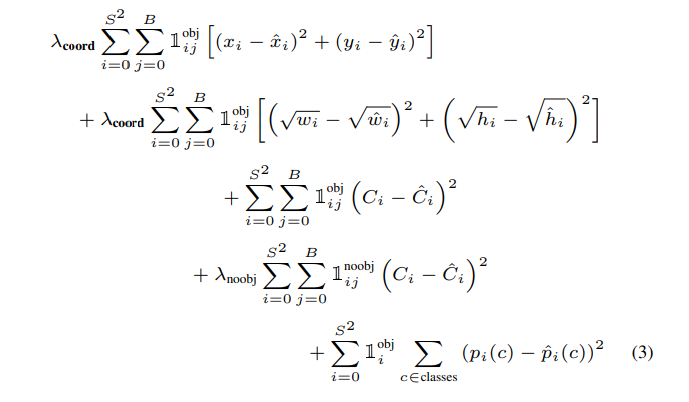

What we have here is a bit long loss function but we can understand it by diving it into smaller pieces.

In the first line we see the loss for midpoints. Lets just ignore lambda values for now (Lambda_coord , Lambda_noobj). 
We see a basic mse loss with the indicator function in front of it. In simple words it says; sum up all the distances between the target and prediction midpoints for all grids iff grid i contains an object and bounding box j is "responsible" for outputing that object. Now here responsible means that the bounding box with the highest IOU(intersection over union) score with the target box. So which means we ignore the grid i that does not contain an object and also the bounding boxes that are not responsible. In this way we just penalize the model for the distance for true labels. 

In the second line everyhing is the same except now we calculate the distances for width and height. The reason we use sqrt here is we dont want to penalize the model for the difference of w and h for large objects. And the rest is the same for indcator and bounding boxes.

In the third line we calculate the confidance score loss which means if there was an object at grid i and responsible bounding box had a confidence score for that object, how bad our prediction is? And we still just calculate it for responsible bounding boxes and True labeled grids.


The fourth part that is the inverse of part 3 we calculate the same thing for no object at grid i and the responsible bounding box j.

And lastly, we calculate the differences of probabilities of class predictions and ground truth labels if the grid i contains an object. 


The lamdas here helps us to modify the loss we set Lambda_noobj to 0.5 and Lambda_coord to 5 here what we do is, we are pushing the model for better bounding box predictions and we give some room to model for wrong object predictions.

In [31]:
class LossFunction(nn.Module):
    def __init__(self , grid_size = 7 ,n_box = 2 , n_class = 20,lambda_coord = 5, lambda_noobj = 0.5):
        super(LossFunction,self).__init__()
        self.mse = nn.MSELoss(reduction = "sum")  # 均方误差损失函数
        self.lambda_coord = lambda_coord  # 坐标预测的损失权重
        self.lambda_noobj = lambda_noobj  # 对象不存在的置信度损失权重
        self.n_grid = grid_size  # 网格大小
        self.n_box = n_box  # 每个网格预测的边界框数量
        self.n_class = n_class  # 类别数量


    """
    C: Confidience that there is an object
    X , Y , W , H: (X , Y) midpoints of an object and (W, H) is the width and the height 
    cn: object Class n lower c means class probability. 
    1 grid prediction [C1 X1 Y1 W1 H1 C2 X2 Y2 W2 H2 c1 c2 c3 ... c(n_class)] we constrain the grids so that each grid can only contain 1 object
    1 grid Target [C X Y W H c1 c2 c3 ... c(n_class)]
    Target.shape = [N , S , S , (5 + c)]
    preds.shape =  [N, S , S ,(c + 5*B)]
    """    
            
    def forward(self,preds , target):
        # preds是模型的预测输出，target是真实的标签
        # 首先，将预测输出reshape成[N, S , S ,(c + 5*B)]的形状
        predictions = preds.reshape(-1,self.n_grid , self.n_grid ,(5 * self.n_box + self.n_class)) 

        # 计算每个预测边界框与真实边界框的IoU
        iou1 = IOU(predictions[... , 1:5] , target[... , 1:5])
        iou2 = IOU(predictions[... , 6:10] , target[... , 1:5])
        ious = torch.cat([iou1.unsqueeze(0), iou2.unsqueeze(0)], dim=0) 

        # 选择IoU最大的预测边界框
        iou_maxes, bestbox = torch.max(ious, dim=0) 

        # 判断每个网格是否存在对象
        exists_box = target[..., 0].unsqueeze(3) 

        # 计算边界框预测的损失
        box_predictions = exists_box * (bestbox * predictions[..., 6:10] + (1 - bestbox) * predictions[..., 1:5])
        box_target = exists_box * target[... , 1:5]
        box_preds = torch.sign(box_predictions[... , 2:4])*torch.sqrt(torch.abs(box_predictions[... , 2:4] + 1e-6)) 
        box_target = box_target[... , 2:4]*torch.sqrt(box_target[... , 2:4])
        box_loss = self.mse(torch.flatten(box_preds, end_dim = -2), torch.flatten(box_target, end_dim = -2))

        # 计算对象存在的置信度损失
        obj_box_conf = exists_box *(bestbox * predictions[..., 5:6] + (1 - bestbox) * predictions[..., 0:1])
        object_loss = self.mse(torch.flatten(obj_box_conf, end_dim=-2), torch.flatten(exists_box * target[..., 0:1], end_dim=-2))

        # 计算对象不存在的置信度损失
        bbox_j = (1 - exists_box)*(bestbox * predictions[... , 4:5] + (1-bestbox)*predictions[... , 0:1])
        no_object_loss = self.mse(torch.flatten(bbox_j,end_dim=-2), torch.flatten((1 - exists_box) * target[..., 0:1], end_dim=-2))

        # 计算类别预测的损失
        class_loss = self.mse(torch.flatten(exists_box * predictions[..., 10:], end_dim=-2), torch.flatten(exists_box * target[..., 5:], end_dim=-2))

        # 计算总的损失
        loss = (self.lambda_coord * box_loss + object_loss + self.lambda_noobj * no_object_loss + class_loss)

        return loss

## Dataset

In [32]:
import glob  # 导入glob模块，用于文件路径名的模式匹配

# 使用glob.glob函数获取"../input/pascalvoc-yolo/labels/"目录下所有的.txt文件的路径，返回一个列表
label_path = glob.glob("./labels/*.txt") 

# 使用glob.glob函数获取"../input/pascalvoc-yolo/images/"目录下所有的.jpg文件的路径，返回一个列表
img_path = glob.glob("./images/*.jpg") 

# 打印出标签文件和图像文件的数量
print("# text data is: ",len(label_path) , "# Images: ",len(img_path)) 




# text data is:  21503 # Images:  43223


这段代码定义了一个名为`VOCDataset`的PyTorch数据集类，用于加载和处理视觉对象分类（Visual Object Classes，VOC）数据集的图像和标签。以下是代码的主要功能：

1. **数据加载：**
   - 使用`glob.glob`函数获取指定目录下所有的.txt文件路径，这些文件包含标签信息。
   - 通过读取每个标签文件，将文件名添加到`index_allocator`列表中，并将标签信息解析为包含类别、坐标等信息的numpy数组。

2. **标签处理：**
   - 通过计算网格坐标，将标签信息映射到一个形状为(7,7,25)的全零数组`labels`中。这个数组表示7x7的网格，每个网格包含25个元素，其中包括类别信息、坐标信息等。
   - 使用独热编码（one-hot encoding）将类别信息转换为长度为20的数组，并与坐标等信息合并，然后存储到`labels`数组的对应位置。

3. **图像加载和处理：**
   - 构建图像文件路径，并使用PIL库打开图像文件。
   - 将图像大小调整为448x448像素。

4. **数据存储：**
   - 将处理后的标签`labels`和图像添加到`self.datadict`字典中，其中键是数据样本的索引。

5. **数据集长度和样本获取：**
   - `__len__`方法返回数据集中样本的数量，即`self.datadict`的长度。
   - `__getitem__`方法根据索引返回对应的样本，包括经过处理的图像数据和标签数据。

总体而言，该代码的目的是将VOC数据集的图像和标签加载并整理成适用于深度学习模型训练的形式。这个数据集类可以用于创建PyTorch的数据加载器，以便在深度学习模型中使用VOC数据进行训练。

In [36]:

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self):
        # 使用glob.glob函数获取"./labels/"目录下所有的.txt文件的路径
        label_path = glob.glob("./labels/*.txt") 

        # 初始化一个空字典self.datadict和一个空列表index_allocator
        self.datadict = {}
        index_allocator = []

        # 设置一个变量a，其值为1/7
        a = 1/7

        # 设置一个变量restriction，其初始值为0，用于限制加载的图像数量
        restriction = 0 

        # 遍历每个标签文件
        for filename in label_path:
            # 获取文件名（不包括扩展名）
            file_number = os.path.splitext(os.path.basename(filename))[0]

            # 读取文件内容，将换行符替换为空格，并将结果分割为一个列表
            lines = open(filename).read().replace("\n", " ")
            l = [
                float(x) if float(x) != int(float(x)) else int(x)
                for x in lines.split()
            ]

            # 将文件名添加到index_allocator列表中
            index_allocator.append(file_number)

            # 创建一个形状为(7,7,25)的全零数组labels
            labels = np.zeros((7,7,25))

            # 将l转换为numpy数组，并reshape为(-1,5)的形状
            l = np.array(l).reshape(-1,5) 

            # 遍历l中的每个元素i
            for i in l:
                # 计算x和y的网格坐标
                x_grid = i[1]/a
                y_grid = i[2]/a

                # 创建一个长度为20的全零数组one_hot，并将i[0]位置的元素设置为1
                one_hot = np.zeros((20))
                one_hot[int(i[0])] = 1

                # 将one_hot和其他信息合并，并存储到labels中对应的位置
                labels[int(x_grid),int(y_grid)] = np.concatenate( ( np.array([1 ,(i[1] % 1),(i[2]%1) , i[3] , i[4]]) , one_hot ) ,axis = 0)

            # 将labels添加到self.datadict中
            self.datadict[len(index_allocator)-1] = [labels]    

            # 如果restriction达到500，则跳出循环
            if restriction == 500:
                break

            # 否则，restriction加1
            restriction += 1 

        # 遍历index_allocator中的每个元素img_name
        for img_name in index_allocator:
            # 拼接出图像文件的路径
            img_path = "./images/"+img_name+".jpg"

            # 打开图像文件，并将其大小调整为448x448
            img = Image.open(img_path)
            img = img.resize((448,448))

            # 将图像添加到self.datadict中对应的键值下
            self.datadict[index_allocator.index(img_name)].append(img)

        # 删除index_allocator
        del index_allocator

    def __len__(self):
        # 返回数据集中的样本数量，即self.datadict的长度
        return len(self.datadict)

    def __getitem__(self, index):
        # 返回指定索引的样本，包括图像和标签
        # 图像数据首先被转换为numpy数组，然后进行维度重排，最后转换为torch张量
        # 标签数据直接从self.datadict中获取并转换为torch张量
        return torch.tensor(np.array(self.datadict[index][1])).permute(2,0,1).to(torch.float) , torch.tensor(self.datadict[index][0])

In [39]:
## Testing the dataset
custom_dataset = VOCDataset()

In [44]:
custom_dataset.__len__()

501

## Training and evaluation

In [47]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

# 创建一个YoloV1模型实例，参数为(7,2,20)
model = YoloV1(7,2,20)

# 创建一个损失函数实例
loss =  LossFunction()

# 检测是否有可用的GPU，选择设备
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 创建一个Adam优化器实例
optimizer = optim.Adam(
        model.parameters(), lr=2e-5, weight_decay=0
    )

# 创建一个数据加载器实例
dataloader = DataLoader(dataset = custom_dataset , batch_size = 32  , shuffle = True )

# 创建一个tqdm实例用于显示训练进度
loop = tqdm(dataloader, leave=True)

# 将模型移动到指定设备上，并设置为训练模式
model.to(device)
model.train()

# 设置训练的轮数
epochs = 20

# 初始化损失值和损失列表
optimizer.zero_grad()
losses = 0
loss_list = []

# 开始训练循环
for i in range(epochs):
    
    for batch_index ,(inp , target) in enumerate(loop):
        optimizer.zero_grad()
        inp = inp.to(device)
        target = target.to(device)
            
        # 模型前向传播
        out = model(inp)
        
        # 计算损失并将损失值添加到损失列表中
        losses = loss(out , target)
        loss_list.append(losses.item())
        
        # 反向传播和参数更新
        losses.backward()
        optimizer.step()
        loop.set_postfix(loss = losses.item())
        
        # 释放内存
        del inp
        del target
        del out
    
    # 打印平均损失
    print(f"Mean loss was {sum(loss_list)/len(loss_list)}")

100%|██████████| 16/16 [01:59<00:00,  7.49s/it, loss=245]


Mean loss was 412.1472602999469
Mean loss was 330.3207802795032
Mean loss was 290.79515529117367
Mean loss was 267.681126102111
Mean loss was 251.8159853257674
Mean loss was 239.92508701001404
Mean loss was 234.72978599661909
Mean loss was 229.19293189760754
Mean loss was 224.1207801539784
Mean loss was 219.08220449516298
Mean loss was 214.05748175418086
Mean loss was 209.83297677670558
Mean loss was 206.07070138930916
Mean loss was 202.4677516325681
Mean loss was 199.31915965694532
Mean loss was 196.51437637290584
Mean loss was 194.16295206629692
Mean loss was 191.6756584366751
Mean loss was 189.14990320985535
Mean loss was 186.79873820539981


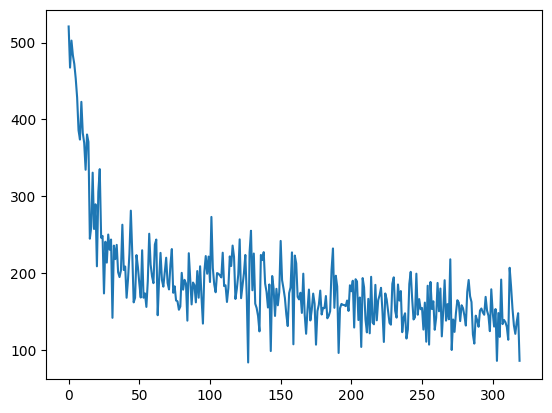

In [48]:
# 导入matplotlib.pyplot模块
import matplotlib.pyplot as plt

# 创建一个新的图形
plt.figure()

# 绘制损失列表的折线图
plt.plot(loss_list)

In [49]:
# 计算步长
x = len(loss_list)/(300)

# 初始化一个空列表用于存储采样后的损失值
clear = []

# 遍历50次，按照步长采样损失值并添加到clear列表中
for i in range(50):
    clear.append(loss_list[int(i*x)])

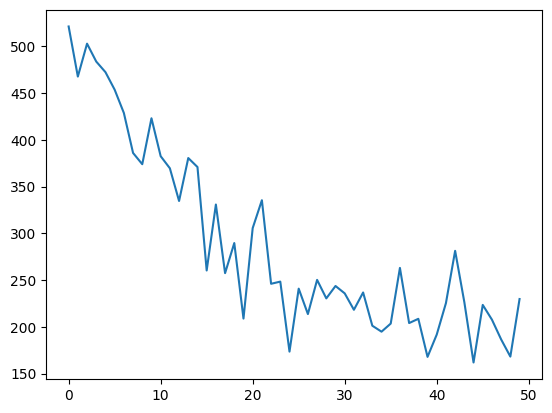

In [50]:
plt.figure()
plt.plot(clear)